## Load modules.

In [126]:
#Import module
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

import re

## Read gene count table

In [127]:
data=pd.read_csv('../diff-cancer/machine-classifer/featurecounts-longRNA.txt',sep="\t")
label=pd.read_csv('../diff-cancer/machine-classifer/featurecount_sample_classes-longRNA.txt',sep="\t")

print(type(data))
print(data.head())
print(type(label))
print(label.head())

<class 'pandas.core.frame.DataFrame'>
                                             feature  SRR5679904  SRR5679905  \
0  ENSG00000243485.5|lncRNA|MIR1302-2HG|ENSG00000...           0           0   
1  ENSG00000237613.2|lncRNA|FAM138A|ENSG000002376...           0           0   
2  ENSG00000186092.5|mRNA|OR4F5|ENSG00000186092.5...           0           0   
3  ENSG00000238009.6|lncRNA|AL627309.1|ENSG000002...           1          11   
4  ENSG00000239945.1|lncRNA|AL627309.3|ENSG000002...           0           0   

   SRR5679906  SRR5679907  SRR5679908  SRR5679909  SRR5687235  SRR5687236  \
0           0           0           0           0           2           0   
1           8           0           0           0           0           0   
2           0           0           0           0           0           0   
3           6           8          10           0          15           1   
4           6           0           0           0           4           0   

   SRR5687237     

In [128]:
#data.iloc[0,0]
#d1=data.loc[data['feature']=='hsa-let-7a-2-3p|miRNA|hsa-let-7a-2-3p|hsa-let-7a-2-3p|hsa-let-7a-2-3p|0|22']
#
d1=data
d2=label.iloc[:,1].values
d2_unique=np.unique(d2)

#type(d2)
#print(d2)
print(d2_unique)

['CHD' 'CRC' 'HCC' 'Healthy' 'PAAD']


## Normolize by sample with CPM

In [129]:
#get dataframe shape
shape=data.shape

#divide gene counts and gene name
data_without_gene=data.iloc[:,1:shape[1]-1]
data_name=data.iloc[:,0]

#
#data_without_gene
#Sum each columns.
data_without_gene_sum=data_without_gene.sum()

#Calculate scale factor with cpm.
data_without_gene_sum_scale=data_without_gene_sum/1000000
data_without_gene_sum_scale=data_without_gene_sum_scale.values
data_without_gene_sum_scale

#Normolization gene counts with scale factor
data_without_gene_norm=data_without_gene/data_without_gene_sum_scale

#merge data frame
data_without_gene_norm_complete=pd.concat([data_name,data_without_gene_norm],axis=1)
data_without_gene_norm_complete.head()


,feature,SRR5679904,SRR5679905,SRR5679906,SRR5679907,SRR5679908,SRR5679909,SRR5687235,SRR5687236,SRR5687237,...,SRR5714911,SRR5714912,SRR5714913,SRR5714914,SRR5714915,SRR5714916,SRR5714917,SRR5714918,SRR5714919,SRR5714920
0,ENSG00000243485.5|lncRNA|MIR1302-2HG|ENSG00000...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.477332,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,ENSG00000237613.2|lncRNA|FAM138A|ENSG000002376...,0.000000,0.000000,3.836579,0.000000,0.000000,0.0,0.000000,0.000000,0.142731,...,0.476697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.277733
2,ENSG00000186092.5|mRNA|OR4F5|ENSG00000186092.5...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,1.071889,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,ENSG00000238009.6|lncRNA|AL627309.1|ENSG000002...,0.608422,12.529259,2.877434,6.332275,3.966172,0.0,3.579989,0.289279,1.855506,...,2.383483,0.000000,0.699733,5.832423,0.769242,3.043868,9.988537,0.0,0.0,1.388664
4,ENSG00000239945.1|lncRNA|AL627309.3|ENSG000002...,0.000000,0.000000,2.877434,0.000000,0.000000,0.0,0.954664,0.000000,0.713656,...,0.476697,0.000000,0.000000,0.000000,0.769242,0.563679,2.118781,0.0,0.0,0.277733


## Label and Counts

In [130]:
print(d2_unique)

['CHD' 'CRC' 'HCC' 'Healthy' 'PAAD']


In [131]:
# Get label class.
label_class=label['label'].unique()
print(label_class)

def get_label_class_by_name(name):
    label_healthy=label.loc[label['label']==name]
    healthy=label_healthy.iloc[:,0].values
    healthy2=np.append(['feature'],healthy)
    return healthy2

#Get CHD
CHD2=get_label_class_by_name('CHD')
print(CHD2)

#Get CRC
CRC2=get_label_class_by_name('CRC')
print(CRC2)

#Get HCC
HCC2=get_label_class_by_name('HCC')
print(HCC2)

#Get healty class    
Healthy2=get_label_class_by_name('Healthy')
print (Healthy2)

#Get PAAD
PAAD2=get_label_class_by_name('PAAD')
print(PAAD2)



['Healthy' 'HCC' 'CRC' 'CHD' 'PAAD']
['feature' 'SRR5679904' 'SRR5679905' 'SRR5679906' 'SRR5679907'
 'SRR5679908' 'SRR5679909']
['feature' 'SRR5687235' 'SRR5687236' 'SRR5687237' 'SRR5687238'
 'SRR5687239' 'SRR5687240' 'SRR5687241' 'SRR5687242' 'SRR5687243'
 'SRR5687244' 'SRR5687245' 'SRR5687246']
['feature' 'SRR5712516' 'SRR5712517' 'SRR5712518' 'SRR5712519'
 'SRR5712520' 'SRR5712521' 'SRR5712522' 'SRR5712523' 'SRR5712524'
 'SRR5712525' 'SRR5712526' 'SRR5712527' 'SRR5712528' 'SRR5712529'
 'SRR5712530' 'SRR5712531' 'SRR5712532' 'SRR5712533' 'SRR5712534'
 'SRR5712535' 'SRR5712536']
['feature' 'SRR5712482' 'SRR5712483' 'SRR5712484' 'SRR5712485'
 'SRR5712486' 'SRR5712487' 'SRR5712488' 'SRR5712489' 'SRR5712490'
 'SRR5712491' 'SRR5712492' 'SRR5712493' 'SRR5712494' 'SRR5712495'
 'SRR5712496' 'SRR5712497' 'SRR5712498' 'SRR5712499' 'SRR5712500'
 'SRR5712501' 'SRR5712502' 'SRR5712503' 'SRR5712504' 'SRR5712505'
 'SRR5712506' 'SRR5712507' 'SRR5712508' 'SRR5712509' 'SRR5712510'
 'SRR5712511' 'SRR57

In [132]:
print(PAAD2)
label.loc[label['label']=='PAAD']

['feature' 'SRR5714908' 'SRR5714909' 'SRR5714910' 'SRR5714911'
 'SRR5714912' 'SRR5714913' 'SRR5714914' 'SRR5714915' 'SRR5714916'
 'SRR5714917' 'SRR5714918' 'SRR5714919' 'SRR5714920' 'SRR5714921']


,sample_id,label
71,SRR5714908,PAAD
72,SRR5714909,PAAD
73,SRR5714910,PAAD
74,SRR5714911,PAAD
75,SRR5714912,PAAD
76,SRR5714913,PAAD
77,SRR5714914,PAAD
78,SRR5714915,PAAD
79,SRR5714916,PAAD
80,SRR5714917,PAAD


## Generate arrays: expression and label.

In [133]:
healty_count=data_without_gene_norm_complete[Healthy2]

CHD_count=data_without_gene_norm_complete[CHD2]
CRC_count=data_without_gene_norm_complete[CRC2]
HCC_count=data_without_gene_norm_complete[HCC2]
Healthy_count=data_without_gene_norm_complete[Healthy2]

PAAD_count=data_without_gene_norm_complete[PAAD2[:-1]]




In [134]:
CRC_count.head()
CRC_count.iloc[0,0]

'ENSG00000243485.5|lncRNA|MIR1302-2HG|ENSG00000243485.5|ENSG00000243485.5|0|1021'

## Select one gene to plot auc.

In [135]:
gene_name='ENSG00000243485.5|lncRNA|MIR1302-2HG|ENSG00000243485.5|ENSG00000243485.5|0|1021'
roc_calcualte_all(gene_name,Healthy_count,CRC_count)

[[0.5833333333333334,
  array([0., 0., 0., 1.]),
  array([0.        , 0.08333333, 0.16666667, 1.        ])],
 [0.5833333333333334,
  array([0., 0., 0., 1.]),
  array([0.        , 0.08333333, 0.16666667, 1.        ])],
 [0.5833333333333334, array([0., 1.]), array([0.16666667, 1.        ])]]

In [136]:
def roc_calcualte_plot(gene_name,Healthy_count,Cancer_count):
    #Select biomarker by gene name.
    control=Healthy_count.loc[Healthy_count['feature']==gene_name]
    cancer=Cancer_count.loc[Cancer_count['feature']==gene_name]

    #Remove the name
    control2=control.iloc[:,1:control.shape[1]].values
    cancer2=cancer.iloc[:,1:cancer.shape[1]].values
    Expression2=np.append(control2[0],cancer2[0])

    #set class label
    control_label=np.repeat(0,control2[0].shape)
    cancer_label=np.repeat(1,cancer2[0].shape)

    #merge label
    Label2=np.append(control_label,cancer_label)

    #input data
    Expression=np.asarray(Expression2)
    Label=np.asarray(Label2)

    # set dictory
    Fpr = dict()
    Tpr = dict()
    Roc_auc = dict()

    #calculate FPR, TPR and ROC
    Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
    Roc_auc[0] = auc(Fpr[0], Tpr[0])

    #Calculate micro-FPR, micro-TPR and micro-AUC
    Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
    Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])

    # Compute macro-average ROC curve and ROC area


    # First aggregate all false positive rates
    All_Fpr = np.unique(Fpr[0])


    # Then interpolate all ROC curves at this points
    mean_Tpr = np.zeros_like(All_Fpr)
    mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])


    # Finally average it and compute AUC

    Fpr["macro"] = All_Fpr
    Tpr["macro"] = mean_Tpr
    Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])

    if(Roc_auc[0]<0.5):
        control_label=np.repeat(1,control2[0].shape)
        cancer_label=np.repeat(0,cancer2[0].shape)
        Label2=np.append(control_label,cancer_label)
        Label=np.asarray(Label2)
        # set dictory
        Fpr = dict()
        Tpr = dict()
        Roc_auc = dict()
        #calculate FPR, TPR and ROC
        Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
        Roc_auc[0] = auc(Fpr[0], Tpr[0])
        #Calculate micro-FPR, micro-TPR and micro-AUC
        Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
        Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        All_Fpr = np.unique(Fpr[0])
        # Then interpolate all ROC curves at this points
        mean_Tpr = np.zeros_like(All_Fpr)
        mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])
        # Finally average it and compute AUC
        Fpr["macro"] = All_Fpr
        Tpr["macro"] = mean_Tpr
        Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])
        
    names_plt=gene_name.split('|')

    # Plot all ROC curves
    color='cornflowerblue'
    lw=2
    plt.figure(figsize=(8, 8))
    plt.plot(Fpr["micro"], Tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(Roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(Fpr["macro"], Tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(Roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])


    plt.plot(Fpr[0], Tpr[0], color=color, lw=lw,
        label='ROC curve of class (area = {1:0.2f})'
        ''.format(0, Roc_auc[0]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(names_plt[0]+' Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [137]:
def roc_calcualte(gene_name,Healthy_count,Cancer_count):
    #Select biomarker by gene name.
    control=Healthy_count.loc[Healthy_count['feature']==gene_name]
    cancer=Cancer_count.loc[Cancer_count['feature']==gene_name]

    #Remove the name
    control2=control.iloc[:,1:control.shape[1]].values
    cancer2=cancer.iloc[:,1:cancer.shape[1]].values
    Expression2=np.append(control2[0],cancer2[0])

    #set class label
    control_label=np.repeat(0,control2[0].shape)
    cancer_label=np.repeat(1,cancer2[0].shape)

    #merge label
    Label2=np.append(control_label,cancer_label)

    #input data
    Expression=np.asarray(Expression2)
    Label=np.asarray(Label2)

    # set dictory
    Fpr = dict()
    Tpr = dict()
    Roc_auc = dict()

    #calculate FPR, TPR and ROC
    Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
    Roc_auc[0] = auc(Fpr[0], Tpr[0])

    #Calculate micro-FPR, micro-TPR and micro-AUC
    Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
    Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])

    # Compute macro-average ROC curve and ROC area


    # First aggregate all false positive rates
    All_Fpr = np.unique(Fpr[0])


    # Then interpolate all ROC curves at this points
    mean_Tpr = np.zeros_like(All_Fpr)
    mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])


    # Finally average it and compute AUC

    Fpr["macro"] = All_Fpr
    Tpr["macro"] = mean_Tpr
    Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])

    if(Roc_auc[0]<0.5):
        control_label=np.repeat(1,control2[0].shape)
        cancer_label=np.repeat(0,cancer2[0].shape)
        Label2=np.append(control_label,cancer_label)
        Label=np.asarray(Label2)
        # set dictory
        Fpr = dict()
        Tpr = dict()
        Roc_auc = dict()
        #calculate FPR, TPR and ROC
        Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
        Roc_auc[0] = auc(Fpr[0], Tpr[0])
        #Calculate micro-FPR, micro-TPR and micro-AUC
        Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
        Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        All_Fpr = np.unique(Fpr[0])
        # Then interpolate all ROC curves at this points
        mean_Tpr = np.zeros_like(All_Fpr)
        mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])
        # Finally average it and compute AUC
        Fpr["macro"] = All_Fpr
        Tpr["macro"] = mean_Tpr
        Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])
    return Roc_auc[0]

In [138]:
def roc_calcualte_all(gene_name,Healthy_count,Cancer_count):
    #Select biomarker by gene name.
    control=Healthy_count.loc[Healthy_count['feature']==gene_name]
    cancer=Cancer_count.loc[Cancer_count['feature']==gene_name]

    #Remove the name
    control2=control.iloc[:,1:control.shape[1]].values
    cancer2=cancer.iloc[:,1:cancer.shape[1]].values
    Expression2=np.append(control2[0],cancer2[0])

    #set class label
    control_label=np.repeat(0,control2[0].shape)
    cancer_label=np.repeat(1,cancer2[0].shape)

    #merge label
    Label2=np.append(control_label,cancer_label)

    #input data
    Expression=np.asarray(Expression2)
    Label=np.asarray(Label2)

    # set dictory
    Fpr = dict()
    Tpr = dict()
    Roc_auc = dict()

    #calculate FPR, TPR and ROC
    Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
    Roc_auc[0] = auc(Fpr[0], Tpr[0])

    #Calculate micro-FPR, micro-TPR and micro-AUC
    Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
    Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])

    # Compute macro-average ROC curve and ROC area


    # First aggregate all false positive rates
    All_Fpr = np.unique(Fpr[0])


    # Then interpolate all ROC curves at this points
    mean_Tpr = np.zeros_like(All_Fpr)
    mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])


    # Finally average it and compute AUC

    Fpr["macro"] = All_Fpr
    Tpr["macro"] = mean_Tpr
    Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])

    if(Roc_auc[0]<0.5):
        control_label=np.repeat(1,control2[0].shape)
        cancer_label=np.repeat(0,cancer2[0].shape)
        Label2=np.append(control_label,cancer_label)
        Label=np.asarray(Label2)
        # set dictory
        Fpr = dict()
        Tpr = dict()
        Roc_auc = dict()
        #calculate FPR, TPR and ROC
        Fpr[0], Tpr[0], _= roc_curve(Label, Expression)
        Roc_auc[0] = auc(Fpr[0], Tpr[0])
        #Calculate micro-FPR, micro-TPR and micro-AUC
        Fpr["micro"], Tpr["micro"], _ = roc_curve(Label.ravel(), Expression.ravel())
        Roc_auc["micro"] = auc(Fpr["micro"], Tpr["micro"])
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        All_Fpr = np.unique(Fpr[0])
        # Then interpolate all ROC curves at this points
        mean_Tpr = np.zeros_like(All_Fpr)
        mean_Tpr += interp(All_Fpr, Fpr[0], Tpr[0])
        # Finally average it and compute AUC
        Fpr["macro"] = All_Fpr
        Tpr["macro"] = mean_Tpr
        Roc_auc["macro"] = auc(Fpr["macro"], Tpr["macro"])
    return [ [Roc_auc[0], Fpr[0], Tpr[0]], [ Roc_auc["micro"], Fpr["micro"], Tpr["micro"]],[Roc_auc["macro"],Fpr["macro"],Tpr["macro"]] ]


In [139]:
names=data_without_gene_norm_complete.iloc[:,0]
names.head()

0    ENSG00000243485.5|lncRNA|MIR1302-2HG|ENSG00000...
1    ENSG00000237613.2|lncRNA|FAM138A|ENSG000002376...
2    ENSG00000186092.5|mRNA|OR4F5|ENSG00000186092.5...
3    ENSG00000238009.6|lncRNA|AL627309.1|ENSG000002...
4    ENSG00000239945.1|lncRNA|AL627309.3|ENSG000002...
Name: feature, dtype: object

In [ ]:

values={}

for x in names:
    #print(x,Healthy_count,CRC_count)
    value=roc_calcualte(x,Healthy_count,CRC_count)
    values[x]=value
        

In [ ]:
print(type(values))
print(len(values))

In [ ]:
out=open('roc-data/crc-vs-health-longRNA.txt','w')
out.write("data_source\tclassification\tname\tauc\tfpr\ttpr\tmicro-auc\tmicro-fpr\tmicor-tpr\tmacro-acu\tmacro-fpr\tmacro-tpr\n")
for name in names:
    string=roc_calcualte_all(name,Healthy_count,CRC_count)
    array1=name.split('|')
    name=array1[0]
    name=name.replace('hsa-','')
    variable1=np.array2string(string[0][0]).replace('\n','')
    variable1=re.sub('\s+',",",variable1)
    variable2=np.array2string(string[0][1]).replace('\n','')
    variable2=re.sub('\s+',",",variable2)
    
    variable3=np.array2string(string[0][2]).replace('\n','')
    variable3=re.sub('\s+',",",variable3)
    
    variable4=np.array2string(string[1][0]).replace('\n','')
    variable4=re.sub('\s+',",",variable4)
    
    variable5=np.array2string(string[1][1]).replace('\n','')
    variable5=re.sub('\s+',",",variable5)
    
    variable6=np.array2string(string[1][2]).replace('\n','')
    variable6=re.sub('\s+',",",variable6)
    
    variable7=np.array2string(string[2][0]).replace('\n','')
    variable7=re.sub('\s+',",",variable7)
    
    variable8=np.array2string(string[2][1]).replace('\n','')
    variable8=re.sub('\s+',",",variable8)
    
    variable9=np.array2string(string[2][2]).replace('\n','')
    variable9=re.sub('\s+',",",variable9)

    out.write("26786760\tCRC-Healthy\t"+str(name)+"\t"+variable1+"\t"+variable2+"\t"+variable3+"\t"+variable4+"\t"+variable5+"\t"+variable6+"\t"+variable7+"\t"+variable8+"\t"+variable9+"\n")

    
    
    


In [155]:
print("hello")

hello


In [156]:
values_sorted=sorted(values.items(), key=lambda x: x[1],reverse=True)
values_table=pd.DataFrame.from_dict(values_sorted)

In [157]:
print(values_table)
values_table.to_csv('healty_vs_CRC-long.csv',  encoding='utf-8')

                                                        0         1
0       ENSG00000202538.1|snRNA|RNU4-2|ENSG00000202538...  0.997396
1       ENSG00000200795.1|snRNA|RNU4-1|ENSG00000200795...  0.997396
2       ENSG00000201801.1|snRNA|RNU5E-4P|ENSG000002018...  0.994792
3       ENSG00000207389.1|snRNA|RNU1-4|ENSG00000207389...  0.994792
4       ENSG00000270103.3|lncRNA|AL360012.1|ENSG000002...  0.994792
5       ENSG00000274978.1|snRNA|RNU11|ENSG00000274978....  0.994792
6       ENSG00000277194.1|snoRNA|SNORD22|ENSG000002771...  0.994792
7       ENSG00000199568.1|snRNA|RNU5A-1|ENSG0000019956...  0.994792
8       ENSG00000200156.1|snRNA|RNU5B-1|ENSG0000020015...  0.994792
9       ENSG00000199805.1|snRNA|RNU1-134P|ENSG00000199...  0.994792
10      ENSG00000222328.1|snRNA|RNU2-2P|ENSG0000022232...  0.992188
11      ENSG00000207005.1|snRNA|RNU1-2|ENSG00000207005...  0.989583
12      ENSG00000207322.1|snRNA|RNU1-89P|ENSG000002073...  0.989583
13      ENSG00000200296.1|snRNA|RNU1-83P|ENSG000

In [158]:
#print(values_table.iloc[1:11,])
for i in range(10):
    print(values_table.iloc[i,0],values_table.iloc[i,1])

ENSG00000202538.1|snRNA|RNU4-2|ENSG00000202538.1|ENSG00000202538.1|0|141 0.9973958333333334
ENSG00000200795.1|snRNA|RNU4-1|ENSG00000200795.1|ENSG00000200795.1|0|141 0.9973958333333334
ENSG00000201801.1|snRNA|RNU5E-4P|ENSG00000201801.1|ENSG00000201801.1|0|120 0.9947916666666667
ENSG00000207389.1|snRNA|RNU1-4|ENSG00000207389.1|ENSG00000207389.1|0|164 0.9947916666666666
ENSG00000270103.3|lncRNA|AL360012.1|ENSG00000270103.3|ENSG00000270103.3|0|131 0.9947916666666666
ENSG00000274978.1|snRNA|RNU11|ENSG00000274978.1|ENSG00000274978.1|0|134 0.9947916666666666
ENSG00000277194.1|snoRNA|SNORD22|ENSG00000277194.1|ENSG00000277194.1|0|126 0.9947916666666666
ENSG00000199568.1|snRNA|RNU5A-1|ENSG00000199568.1|ENSG00000199568.1|0|116 0.9947916666666666
ENSG00000200156.1|snRNA|RNU5B-1|ENSG00000200156.1|ENSG00000200156.1|0|116 0.9947916666666666
ENSG00000199805.1|snRNA|RNU1-134P|ENSG00000199805.1|ENSG00000199805.1|0|165 0.9947916666666666


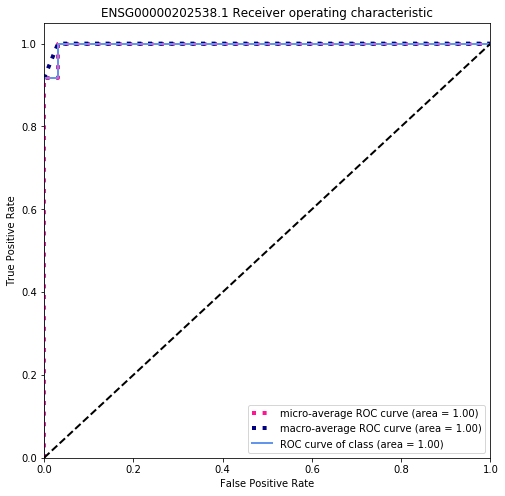

In [159]:
roc_calcualte_plot('ENSG00000202538.1|snRNA|RNU4-2|ENSG00000202538.1|ENSG00000202538.1|0|141',Healthy_count,CRC_count)




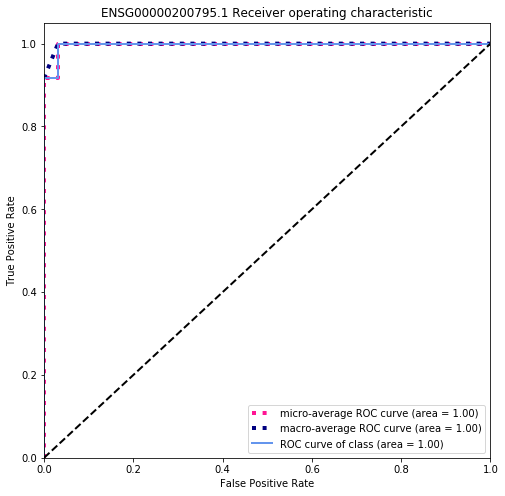

In [161]:
roc_calcualte_plot('ENSG00000200795.1|snRNA|RNU4-1|ENSG00000200795.1|ENSG00000200795.1|0|141',Healthy_count,CRC_count)

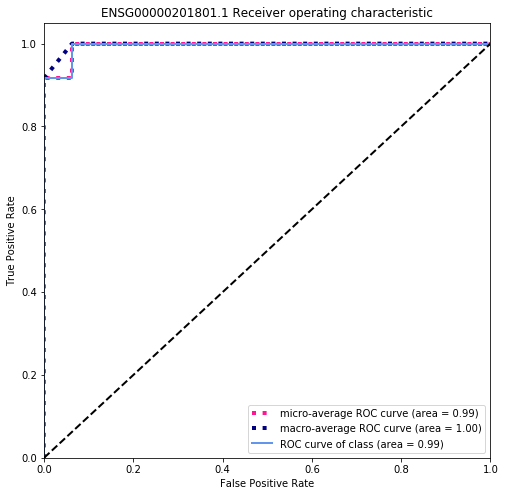

In [162]:
roc_calcualte_plot('ENSG00000201801.1|snRNA|RNU5E-4P|ENSG00000201801.1|ENSG00000201801.1|0|120',Healthy_count,CRC_count)

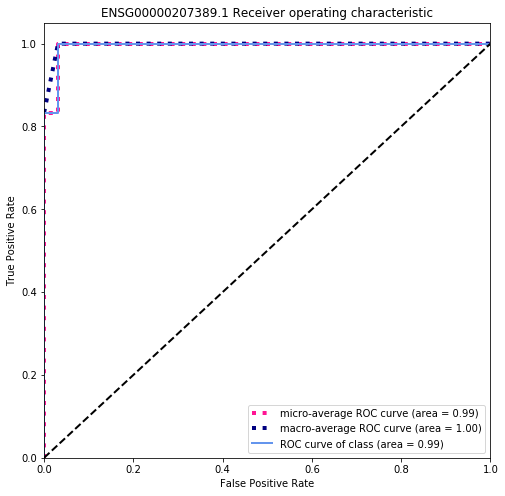

In [163]:
roc_calcualte_plot('ENSG00000207389.1|snRNA|RNU1-4|ENSG00000207389.1|ENSG00000207389.1|0|164',Healthy_count,CRC_count)

## Read biomaker file

In [ ]:
biomarker=pd.read_table('tmp-data/biomaker-id-CRC-0219.txt',sep="\t")
biomarker_name=biomarker.iloc[:,2].values
#print(biomarker_name)
biomarker_name_array=[]
for i in biomarker_name:
    array=i.split(',')
    for j in array:
        biomarker_name_array.append(j)
        
#print(biomarker_name_array)  

### select biomaker 

In [ ]:
#print (values_table)
biomarker_auc=values_table.loc[values_table[0].isin(biomarker_name_array)]
biomarker_auc_values=biomarker_auc.iloc[:,1].values
all_auc_values=values_table.iloc[:,1].values

print(biomarker_auc_values,all_auc_values)

In [ ]:
data = [all_auc_values,biomarker_auc_values]

fig2, ax2 = plt.subplots()
ax2.set_title('AUC of All vs Biomarker in CRC')
ax2.boxplot(data, notch=True)
#plt.plot(all_auc_values,biomarker_auc_values, linewidth=1, color='k')